In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

%matplotlib inline

data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition-Copy1.csv")
data.dropna(inplace=True)
data.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,1,80,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,...,2,80,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,...,2,80,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,2,80,2,17,3,2,7,7,7,7


After uploading my data into 'data', I am no in the process of compiling down my data by extracting and manipulating code into a workable dataset. To do this I first need to determine all the different types of values and convert them into integers so that I can input it into sklearn cross validation.

In [2]:
data.BusinessTravel.value_counts()
data.EducationField.value_counts()
data.isnull().sum().sum()

0

In [3]:
data['IntBusinessTravel'] = data['BusinessTravel'].apply(lambda x:0 if x == "Non-Travel" else (1 if x == "Travel_Rarely" else 2))
data['IntDepartment'] = data['Department'].apply(lambda x:0 if x == "Research & Development" else (1 if x == "Sales" else 2))
data['IntEducationField'] = data['EducationField'].apply(lambda x:0 if x == "Life Sciences" else (1 if x == "Medical" else (2 if x == "Marketing" else (3 if x == 'Technical Degree' else (4 if x == 'Other' else 5)))))
data['IntGender'] = data['Gender'].apply(lambda x:0 if x == "Female" else 1)
data.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,IntBusinessTravel,IntDepartment,IntEducationField,IntGender
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,1,6,4,0,5,1,1,0,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,3,3,10,7,1,7,2,0,0,1
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,3,3,0,0,0,0,1,0,4,1
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,3,8,7,3,0,2,0,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,3,3,2,2,2,2,1,0,1,1
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,2,2,7,7,3,6,2,0,0,1
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,3,2,1,0,0,0,1,0,1,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,...,2,3,1,0,0,0,1,0,0,1
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,...,2,3,9,7,1,8,2,0,0,1
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,3,2,7,7,7,7,1,0,1,1


In [4]:
target = data['Attrition'].copy()
target = target.apply(lambda x:0 if x == "No" else 1)
#newdata = data.drop(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender'], axis=1)
newdata = data[['Age', 'DailyRate', 'IntBusinessTravel', 'IntDepartment', 'IntEducationField', 'IntGender']].copy()

In [5]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

from sklearn.model_selection import cross_val_score
cross_val_score(bnb, newdata, target, cv=10)

array([0.83783784, 0.83783784, 0.83783784, 0.83673469, 0.83673469,
       0.83673469, 0.83673469, 0.84246575, 0.84246575, 0.84246575])

Here I first used a BNB model to try to test against the model for cross validation. With this I was able to achieve a rough .84 accuracy across all my models which is both pretty accurate and clustered, which is good. Now to test it as a decision tree.

--- 0.0 seconds ---


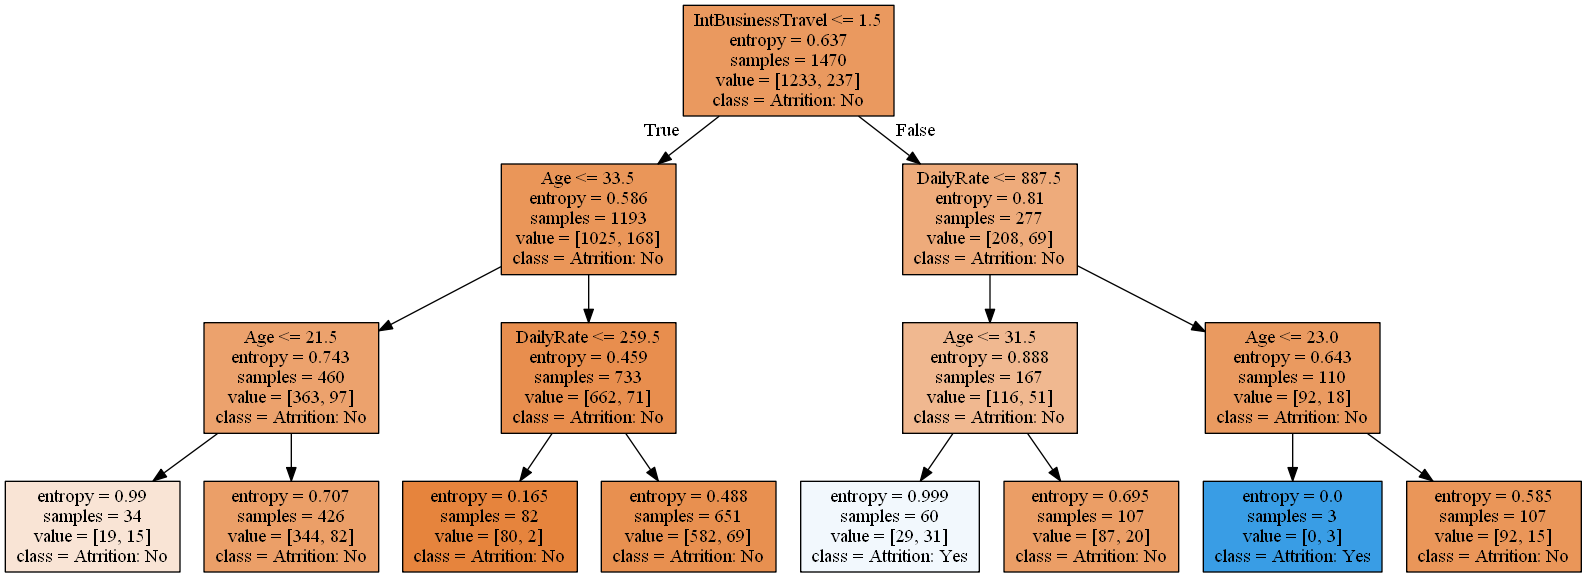

In [6]:
import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 3,
    max_depth = 3
)
decision_tree.fit(newdata,target)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=newdata.columns,
    class_names=['Atrrition: No', 'Attrition: Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [7]:
cross_val_score(decision_tree, newdata, target, cv=10)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2600595951080322 seconds ---


 Using the decision tree I created, it wasn't as percise as the BNB model but still relatively accurate, with fluctuations ranging from .82 to .85! I could probably make this more accurate my increasing the number of features and the depths of the tree to allow for more testing, but I thought a depth of 4 and features at 3 was enough and anymore would make it too much slower for the amount of accuracy it'll attain. Now to test if the random tree is better.

In [8]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, newdata, target, cv=10)

C:\Users\ronal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ronal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ronal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ronal\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\U

array([0.80405405, 0.78378378, 0.82432432, 0.80272109, 0.79591837,
       0.80952381, 0.81632653, 0.84246575, 0.85616438, 0.82191781])

In [9]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.43109869956970215 seconds ---


With the random tree I was able to attain ranges from .79 to .86 roughly. Although still relatively acceptable the variance is much greater in this tree then it is in the decision tree I made and in the BNB model. Time wise, if I include the visual graphs for the decision tree, then the overall process is .25 for it to be compiled, while the random tree takes about .17. 